In [184]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

#from kuramoto import Kuramoto, plot_activity, plot_phase_coherence

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)


In [173]:
import numpy as np
from scipy.integrate import odeint


class Kuramoto:

    def __init__(self, coupling=1, dt=0.01, T=10, n_nodes=None, natfreqs=None):
        '''
        coupling: float
            Coupling strength. Default = 1. Typical values range between 0.4-2
        dt: float
            Delta t for integration of equations.
        T: float
            Total time of simulated activity.
            From that the number of integration steps is T/dt.
        n_nodes: int, optional
            Number of oscillators.
            If None, it is inferred from len of natfreqs.
            Must be specified if natfreqs is not given.
        natfreqs: 1D ndarray, optional
            Natural oscillation frequencies.
            If None, then new random values will be generated and kept fixed
            for the object instance.
            Must be specified if n_nodes is not given.
            If given, it overrides the n_nodes argument.
        '''
        if n_nodes is None and natfreqs is None:
            raise ValueError("n_nodes or natfreqs must be specified")

        self.dt = dt
        self.T = T
        self.coupling = coupling

        if natfreqs is not None:
            self.natfreqs = natfreqs
            self.n_nodes = len(natfreqs)
        else:
            self.n_nodes = n_nodes
            self.natfreqs = np.random.normal(size=self.n_nodes)

    def init_angles(self):
        '''
        Random initial random angles (position, "theta").
        '''
    
        return 2 * np.pi * np.random.random(size=self.n_nodes)

    def derivative(self, angles_vec, t, adj_mat, coupling):
        '''
        Compute derivative of all nodes for current state, defined as

        dx_i    natfreq_i + k  sum_j ( Aij* sin (angle_j - angle_i) )
        ---- =             ---
         dt                M_i

        t: for compatibility with scipy.odeint
        '''
        assert len(angles_vec) == len(self.natfreqs) == len(adj_mat), \
            'Input dimensions do not match, check lengths'

        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        interactions = adj_mat * np.sin(angles_j - angles_i)  # Aij * sin(j-i)

        dxdt = self.natfreqs + coupling * interactions.sum(axis=0)  # sum over incoming interactions
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        '''Updates all states by integrating state of all nodes'''
        # Coupling term (k / Mj) is constant in the integrated time window.
        # Compute it only once here and pass it to the derivative function
        n_interactions = (adj_mat != 0).sum(axis=0)  # number of incoming interactions
        coupling = self.coupling / n_interactions  # normalize coupling by number of interactions

        t = np.linspace(0, self.T, int(self.T/self.dt))
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat, coupling))
        return timeseries.T  # transpose for consistency (act_mat:node vs time)

    def run(self, adj_mat=None, angles_vec=None):
        '''
        adj_mat: 2D nd array
            Adjacency matrix representing connectivity.
        angles_vec: 1D ndarray, optional
            States vector of nodes representing the position in radians.
            If not specified, random initialization [0, 2pi].

        Returns
        -------
        act_mat: 2D ndarray
            Activity matrix: node vs time matrix with the time series of all
            the nodes.
        '''
        if angles_vec is None:
            angles_vec = self.init_angles()

        return self.integrate(angles_vec, adj_mat)

    @staticmethod
    def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

    def mean_frequency(self, act_mat, adj_mat):
        '''
        Compute average frequency within the time window (self.T) for all nodes
        '''
        assert len(adj_mat) == act_mat.shape[0], 'adj_mat does not match act_mat'
        _, n_steps = act_mat.shape

        # Compute derivative for all nodes for all time steps
        dxdt = np.zeros_like(act_mat)
        for time in range(n_steps):
            dxdt[:, time] = self.derivative(act_mat[:, time], None, adj_mat)

        # Integrate all nodes over the time window T
        integral = np.sum(dxdt * self.dt, axis=1)
        # Average across complete time window - mean angular velocity (freq.)
        meanfreq = integral / self.T
        return meanfreq



In [159]:
import matplotlib.pyplot as plt
import numpy as np

#from .kuramoto import Kuramoto


def plot_activity(activity):
    """
    Plot sin(angle) vs time for each oscillator time series.

    activity: 2D-np.ndarray
        Activity time series, node vs. time; ie output of Kuramoto.run()
    return:
        matplotlib axis for further customization
    """
    _, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.sin(activity.T))
    ax.set_xlabel('Time', fontsize=25)
    ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)
    return ax


def plot_phase_coherence(activity):
    """
    Plot order parameter phase_coherence vs time.

    activity: 2D-np.ndarray
        Activity time series, node vs. time; ie output of Kuramoto.run()
    return:
        matplotlib axis for further customization
    """
    _, ax = plt.subplots(figsize=(8, 3))
    ax.plot([Kuramoto.phase_coherence(vec) for vec in activity.T], 'o')
    ax.set_ylabel('Order parameter', fontsize=20)
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylim((-0.01, 1))
    return ax


### Instantiate a random graph and transform into an adjacency matrix

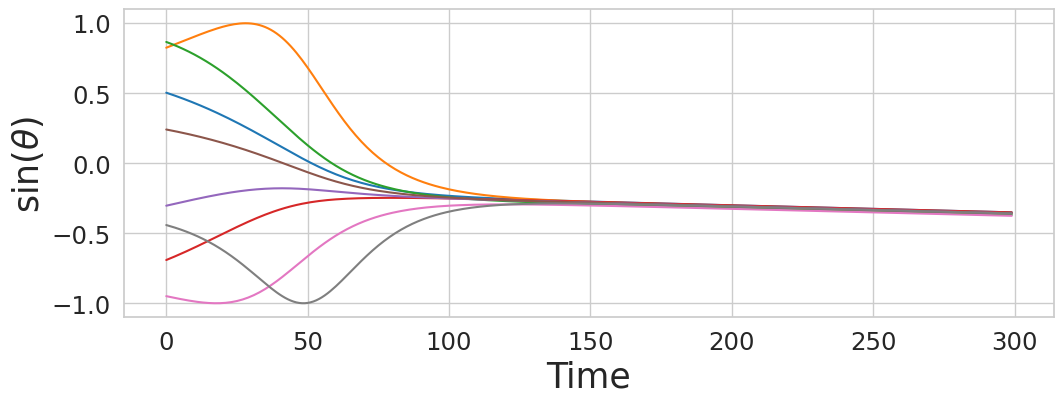

In [204]:
graph_nx = nx.erdos_renyi_graph(n=8, p=1) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)

import random
x = random.randint(1,100)
#print(x) # 9
np.random.seed(9)

model = Kuramoto(coupling=50, dt=0.001, T=0.3, n_nodes=len(graph))       

act_mat = model.run(adj_mat=graph)
#print(act_mat.shape)

plot_activity(act_mat);

In [202]:
import csv


with open('tmp_file.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(act_mat)

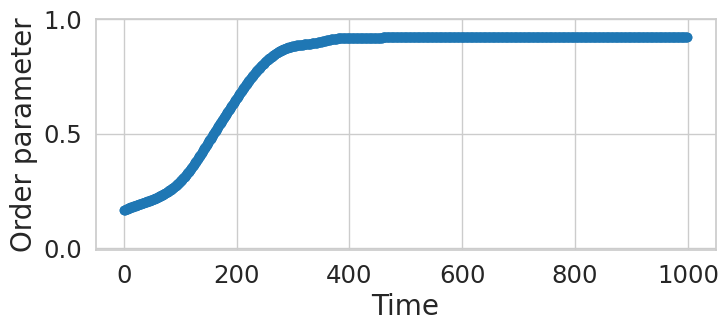

In [15]:
plot_phase_coherence(act_mat);

### Plot oscillators in complex plane at different times

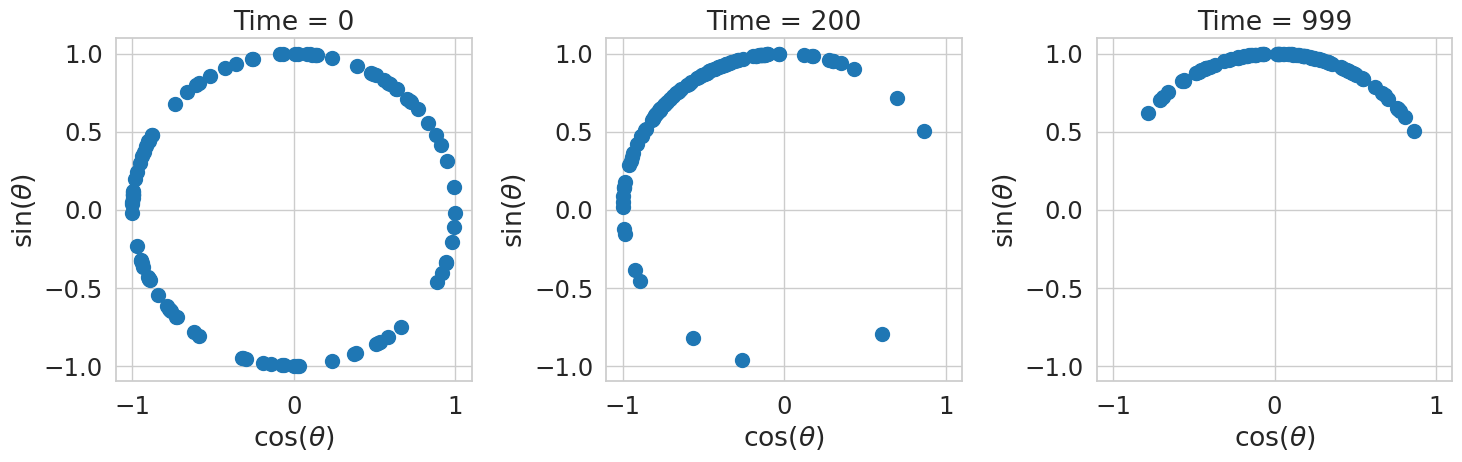

In [83]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5),
                         subplot_kw={
                             "ylim": (-1.1, 1.1),
                             "xlim": (-1.1, 1.1),
                             "xlabel": r'$\cos(\theta)$',
                             "ylabel": r'$\sin(\theta)$',                             
                         })

times = [0, 200, 999]
for ax, time in zip(axes, times):
    ax.plot(np.cos(act_mat[:, time]), 
            np.sin(act_mat[:, time]), 
            'o', 
            markersize=10)
    ax.set_title(f'Time = {time}')
plt.tight_layout()